In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lstmwavenetrc50505020/LSTM_wavenet_RC_5050_5020_Sep27_model_3C.h5
/kaggle/input/lstmwavenetrc50505020/LSTM_wavenet_RC_5050_5020_Sep27_model_4C.h5
/kaggle/input/lstmwavenetrc50505020/LSTM_wavenet_RC_5050_5020_Sep27_model_1C.h5
/kaggle/input/lstmwavenetrc50505020/LSTM_wavenet_RC_5050_5020_Sep27_model_2C.h5
/kaggle/input/d/bobber/vpplstmwavenet/Bidirect_LSTM_wavenet_Sep27_model_2C.h5
/kaggle/input/d/bobber/vpplstmwavenet/Bidirect_LSTM_wavenet_RC_loss_Sep28_model_1C.h5
/kaggle/input/d/bobber/vpplstmwavenet/rwb_100_loops.csv
/kaggle/input/d/bobber/vpplstmwavenet/Bidirect_LSTM_wavenet_Sep27_model_1C.h5
/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv
/kaggle/input/ventilatorpressurepredictionfeatures/train.npy
/kaggle/input/ventilatorpressurepredictionfeatures/test.npy


In [2]:
import gc
import numpy as np
import pandas as pd
import random
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply


# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything()

2021-10-28 23:29:40.432988: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-28 23:29:40.433112: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-28 23:29:45.440216: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-28 23:29:45.443469: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-28 23:29:45.443511: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-28 23:29:45.443541: I tensorflow/stream_executor/cuda/cud

In [3]:
train_df = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [4]:
test_df = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [5]:
all_pressure = np.sort(train_df['pressure'].unique())
pressure_min =  all_pressure[0].item()
pressure_max = all_pressure[-1].item()
pressure_step = (all_pressure[1] - all_pressure[0]).item()

In [6]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"})\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
    
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    df['R_cat'] = df['R'].astype(str)
    df['C_cat'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df


print("Train data...\n")
train = add_features(train_df)

print("\nTest data...\n")
test = add_features(test_df)

del train_df
del test_df
gc.collect()

Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


0

In [7]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

print(f"train: {train.shape} \ntest: {test.shape}")

train: (6036000, 66) 
test: (4024000, 66)


In [8]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print(f"train: {train.shape} \ntest: {test.shape} \ntargets: {targets.shape}")

train: (75450, 80, 66) 
test: (50300, 80, 66) 
targets: (75450, 80)


In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    tpu_strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 256
    print(f"Running on {tpu_strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

2021-10-28 23:33:15.048843: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 23:33:15.050830: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-28 23:33:15.058289: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-28 23:33:15.088467: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-10-28 23:33:15.088528: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-10-28 23:33:15.113165: I tensorflow/core/distributed_runtime

Running on TPU: grpc://10.0.0.2:8470
Batch Size: 512


In [10]:
@tf.custom_gradient
def round_with_gradients(x):
    def grad(dy):
        return dy
    return tf.round(x), grad

class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaleLayer, self).__init__(**kwargs)
        self.min = tf.constant(pressure_min, dtype=np.float32)
        self.max = tf.constant(pressure_max, dtype=np.float32)
        self.step = tf.constant(pressure_step, dtype=np.float32)

    def call(self, inputs):
        steps = tf.math.divide(tf.math.add(inputs, -self.min), self.step)
        int_steps = round_with_gradients(steps)
        rescaled_steps = tf.math.add(tf.math.multiply(int_steps, self.step), self.min)
        clipped = tf.clip_by_value(rescaled_steps, self.min, self.max)
        return clipped

In [11]:
i_wavenet_layer = 0
def wave_block(x, filters, kernel_size, n):
    global i_wavenet_layer
    dilation_rates = [2**i for i in range(n)]
    x = tf.keras.layers.Conv1D(filters = filters,
                kernel_size = 1,
                padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = tf.keras.layers.Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = tf.keras.layers.Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = tf.keras.layers.Multiply(name=f'wavenet_Multiply_{i_wavenet_layer}')([tanh_out, sigm_out])
        x = tf.keras.layers.Conv1D(filters = filters,
                    kernel_size = 1,
                    padding = 'same')(x)
        res_x = tf.keras.layers.Add()([res_x, x])
        i_wavenet_layer += 1
    return res_x

def do_wavenet(inp):
    x = wave_block(inp, 16, 3, 8)
    x = wave_block(x, 32, 3, 12)
    x = wave_block(x, 64, 3, 4)
    x = wave_block(x, 128, 3, 1)
    return x

In [12]:
def dnn_wavenet_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(x3)
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)
    
    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z3 = Bidirectional(GRU(units=256, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z4 = Bidirectional(GRU(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z5 = Bidirectional(GRU(units=64, return_sequences=True))(z51)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5])
    
    #add wavenet
    x = do_wavenet(x)
    global i_wavenet_layer
    i_wavenet_layer += 1
    
    x = Dense(units=128, activation='selu')(x)
    x = Dense(units=1)(x)
    x_output = ScaleLayer()(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [13]:
model = dnn_wavenet_model()
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 66)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 1536)     5130240     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 1024)     8392704     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 768)      4328448     bidirectional_1[0][0]            
__________________________________________________________________________________________

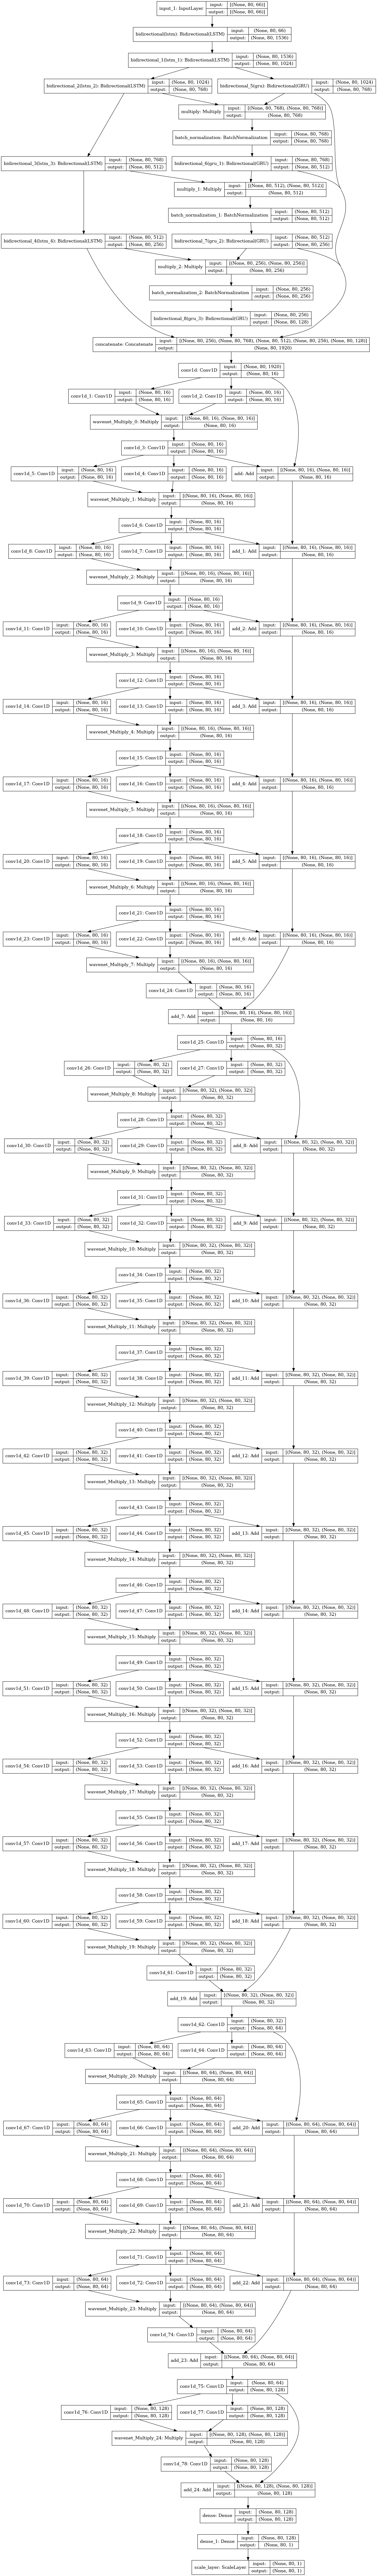

In [14]:
plot_model(
    model, 
    to_file='Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [15]:
IS_TPU = True
BATCH_SIZE=256
with tpu_strategy.scope():
    
    VERBOSE = 2
    EPOCHS = 300
    FOLDS = 7
    
    test_preds = []
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=2021)
    last_test_idx = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):

        #Align data to batch size and drop remainder. We only need it for TPU not GPU
        if IS_TPU:
            X_train, X_valid = train[train_idx], train[test_idx]
            y_train, y_valid = targets[train_idx], targets[test_idx]

            fit_batch_size = X_train.shape[0] - (X_train.shape[0]%BATCH_SIZE)
            print(X_train.shape[0], fit_batch_size)
            X_train, y_train = X_train[:fit_batch_size, :, :], y_train[:fit_batch_size, :]
          
            fit_batch_size = X_valid.shape[0] - (X_valid.shape[0]%BATCH_SIZE)
            print(X_valid.shape[0], fit_batch_size)
            X_valid, y_valid = X_valid[:fit_batch_size, :, :], y_valid[:fit_batch_size, :]
        else:
            X_train, X_valid = train[train_idx], train[test_idx]
            y_train, y_valid = targets[train_idx], targets[test_idx]
        
        
        model = dnn_wavenet_model()
        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                               patience=10, verbose=VERBOSE)
        checkpoint_name = f'./model-gpu/Bidirect_LSTM_model_{fold+1}C.h5'
        chk_point = ModelCheckpoint(checkpoint_name,
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=50,
                           verbose=VERBOSE, mode="min",
                           restore_best_weights=True)
        
       
        model.fit(X_train, y_train, 
                validation_data=(X_valid, y_valid), 
                epochs=EPOCHS,
                verbose=VERBOSE,
                batch_size=BATCH_SIZE, 
                callbacks=[lr, chk_point, es])
        
        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        score = mean_absolute_error(y_true, y_pred)
        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

64671 64512
10779 10752


2021-10-28 23:34:05.018690: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1362493440 exceeds 10% of free system memory.


Epoch 1/300
252/252 - 110s - loss: 1.1652 - val_loss: 0.7792

Epoch 00001: val_loss improved from inf to 0.77916, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 2/300
252/252 - 37s - loss: 0.5485 - val_loss: 0.4810

Epoch 00002: val_loss improved from 0.77916 to 0.48095, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 3/300
252/252 - 37s - loss: 0.4626 - val_loss: 0.4471

Epoch 00003: val_loss improved from 0.48095 to 0.44711, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 4/300
252/252 - 37s - loss: 0.4157 - val_loss: 0.4643

Epoch 00004: val_loss did not improve from 0.44711
Epoch 5/300
252/252 - 37s - loss: 0.3872 - val_loss: 0.3769

Epoch 00005: val_loss improved from 0.44711 to 0.37693, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 6/300
252/252 - 37s - loss: 0.3700 - val_loss: 0.3409

Epoch 00006: val_loss improved from 0.37693 to 0.34092, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 7/300
252/252 - 37s - loss: 0.

2021-10-29 01:43:18.961739: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1062336000 exceeds 10% of free system memory.


InvalidArgumentError: 9 root error(s) found.
  (0) Invalid argument: {{function_node __inference_predict_function_381518}} Compilation failure: Reshape's input dynamic dimension is decomposed into multiple output dynamic dimensions, but the constraint is ambiguous and XLA can't infer the output dimension %reshape.3940 = f32[2,32,40,16]{3,2,1,0} reshape(f32[<=64,40,16]{2,1,0} %reshape.3939), metadata={op_type="BatchToSpaceND" op_name="DNN_Model/conv1d_83/conv1d/BatchToSpaceND"}. 
	TPU compilation failed
	 [[{{node tpu_compile_succeeded_assert/_972842423434287719/_4}}]]
	 [[tpu_compile_succeeded_assert/_972842423434287719/_4/_159]]
  (1) Invalid argument: {{function_node __inference_predict_function_381518}} Compilation failure: Reshape's input dynamic dimension is decomposed into multiple output dynamic dimensions, but the constraint is ambiguous and XLA can't infer the output dimension %reshape.3940 = f32[2,32,40,16]{3,2,1,0} reshape(f32[<=64,40,16]{2,1,0} %reshape.3939), metadata={op_type="BatchToSpaceND" op_name="DNN_Model/conv1d_83/conv1d/BatchToSpaceND"}. 
	TPU compilation failed
	 [[{{node tpu_compile_succeeded_assert/_972842423434287719/_4}}]]
	 [[cluster_predict_function/control_after/_1/_307]]
  (2) Invalid argument: {{function_node __inference_predict_function_381518}} Compilation failure: Reshape's input dynamic dimension is decomposed into multiple output dynamic dimensions, but the constraint is ambiguous and XLA can't infer the output dimension %reshape.3940 = f32[2,32,40,16]{3,2,1,0} reshape(f32[<=64,40,16]{2,1,0} %reshape.3939), metadata={op_type="BatchToSpaceND" op_name="DNN_Model/conv1d_83/conv1d/BatchToSpaceND"}. 
	TPU compilation failed
	 [[{{node tpu_compile_succeeded_assert/_972842423434287719/_4}}]]
	 [[tpu_compile_succeeded_assert/_972842423434287719/_4/_255]]
  (3) Invalid argument: {{function_node __inference_predict_function_381518}} Compilation failure: Reshape's input dynamic dimension is decomposed into multiple output dynamic dimensions, but the constraint is ambiguous and XLA can't infer the output dimension %reshape.3940 = f32[2,32,40,16]{3,2,1,0} reshape(f32[<=64,40,16]{2,1,0} %reshape.3939), metadata={op_type="BatchToSpaceND" op_name="DNN_Model/conv1d_83/conv1d/BatchToSpaceND"}. 
	TPU compilation failed
	 [[{{node tpu_compile_succeeded_assert/_972842423434287719/_4}}]]
	 [[tpu_compile_succeeded_assert/_972842423434287719/_4/_191]]
  (4) Invalid argument: {{function_node __inference_predict_function_381518}} Compilation failure: Reshape's input dynamic dimension is decomposed into multiple output dynamic dimensions, but the constraint is ambiguous and XLA can't infer the output dimension %reshape.3940 = f32[2,32,40,16]{3,2,1,0} reshape(f32[<=64,40,16]{2,1,0} %reshape.3939), metadata={op_type="BatchToSpaceND" op_name="DNN_Model/conv1d_83/conv1d/BatchToSpaceND"}. 
	TPU compilation failed
	 [[{{node tpu_compile_succeeded_assert/_972842423434287719/_4}}]]
	 [[tpu_compile_succeeded_assert/_972842423434287719/_4/_143]]
  (5) Invalid argument: {{function_node __inference_predict_function_381518}} Compilation fail ... [truncated]

## Create submission file

In [ ]:
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
submission["pressure"] = sum(test_preds)/5
submission.to_csv('submission.csv', index=False)

# ENSEMBLE FOLDS WITH MEDIAN
#取中位数
submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
submission.to_csv('submission_median.csv', index=False)


# ENSEMBLE FOLDS WITH MEDIAN AND ROUND PREDICTIONS
submission["pressure"] =\
    np.round( (submission.pressure - pressure_min)/pressure_step ) * pressure_step + pressure_min
submission.pressure = np.clip(submission.pressure, pressure_min, pressure_max)
submission.to_csv('submission_median_round.csv', index=False)